In [95]:
import sys
 
sys.path.append('..')

from sklearn.covariance import graphical_lasso, EmpiricalCovariance, LedoitWolf
from GraphModels.model import DiagDominantPcorrModel
from sklearn.metrics import accuracy_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.stats import multivariate_normal, multivariate_t, kendalltau
import multiprocessing as mp

import logging
import warnings
from collections import defaultdict
import pickle

In [96]:
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

# Utility functions

In [97]:
def sample_from_mixed(n, cov, eps, dof):
    dim = cov.shape[0]
    norm_samples = multivariate_normal.rvs(np.zeros(dim), cov, size=n)
    t_samples = multivariate_t.rvs(np.zeros(dim), cov, df=dof, size=n)
    selector = (np.random.uniform(0, 1, size=n) < eps).astype(int)
    result = norm_samples.T * (1 - selector) + t_samples.T * selector
    return result.T

def flatten_labels(true_adj, pred_adj):
    n = true_adj.shape[0]
    true_labels = true_adj[np.triu_indices(n, k=1)]
    pred_labels = pred_adj[np.triu_indices(n, k=1)]

    return true_labels, pred_labels

def adjacency_from_precision(precision):
    return (precision != 0.).astype(int)

def inner_given_model_experiment(model, S_obs, reg_param, eps_list, n, t_dof, glasso_max_iter):
    local_data = defaultdict(list)
    for eps in eps_list:
        total_skipped = 0
        for n_repl in range(S_obs):
            data = sample_from_mixed(n, model.covariance, eps, t_dof)
            cov_estim = EmpiricalCovariance(assume_centered=True).fit(data).covariance_
            try:
                gl_cov, gl_prec = graphical_lasso(cov_estim, alpha=reg_param, max_iter=glasso_max_iter)

                pred_adj = adjacency_from_precision(gl_prec)
                true_adj = model.adj

                true, pred = flatten_labels(true_adj, pred_adj)
                local_data[eps].append((true, pred))
            except FloatingPointError as e:
                total_skipped += 1
    return local_data

def run_experiments(S_sg, S_obs, N, density, reg_param, eps_list, n, t_dof, glasso_max_iter):
    experiment_data = defaultdict(list)

    models = [DiagDominantPcorrModel(N, density) for _ in range(S_sg)]

    with mp.Pool() as pool:
        waiters = [
            pool.apply_async(inner_given_model_experiment, (model, S_obs, reg_param, eps_list, n, t_dof, glasso_max_iter))
            for model in models
        ]

        for waiter in tqdm(waiters, gui=False):
            process_dict = waiter.get()
            for k in eps_list:
                experiment_data[k].extend(process_dict[k])

    return experiment_data

def apply_metric(data, eps_list, metric):
    res = []
    for k in tqdm(eps_list):
        res.append(np.array([metric(v[0], v[1]) for v in data[k]]).mean())
    
    return res

def kendall_corr_mat(data):
    dim = data.shape[1]
    matrix = np.array([[kendalltau(data[:, i], data[:, j]).statistic for j in range(dim)] for i in range(dim)])

    return matrix

def get_covariance_from(corr_mat, variances):
    pearson_corr = np.sin(np.pi / 2 * corr_mat)
    D = np.diag(1 / np.sqrt(variances))

    return D @ pearson_corr @ D


# Parameters

In [98]:
N = 20
S_obs = 20
S_sg = 400
reg_param = 0.1
eps_list = np.linspace(0, 1, num=10)
n = 1000
density = 0.2
t_dof = 3
glasso_max_iter=500

In [29]:
experiment_data = run_experiments(S_sg, S_obs, N, density, reg_param, eps_list, n, t_dof, glasso_max_iter)

100%|██████████| 400/400 [25:52<00:00,  3.88s/it]


In [70]:
with open('last_experiment_data.bin', 'wb') as f:
    pickle.dump(experiment_data, f)

In [30]:
for k, v in experiment_data.items():
    print(f"{np.around(k, 2)}: {S_obs * S_sg - len(v)} ({(1 - len(v) / S_obs / S_sg) * 100}%)")

0.0: 0 (0.0%)
0.11: 2 (0.02500000000000835%)
0.22: 4 (0.04999999999999449%)
0.33: 3 (0.03749999999999032%)
0.44: 8 (0.09999999999998899%)
0.56: 3 (0.03749999999999032%)
0.67: 6 (0.07500000000000284%)
0.78: 2 (0.02500000000000835%)
0.89: 9 (0.11249999999999316%)
1.0: 5 (0.06249999999999867%)


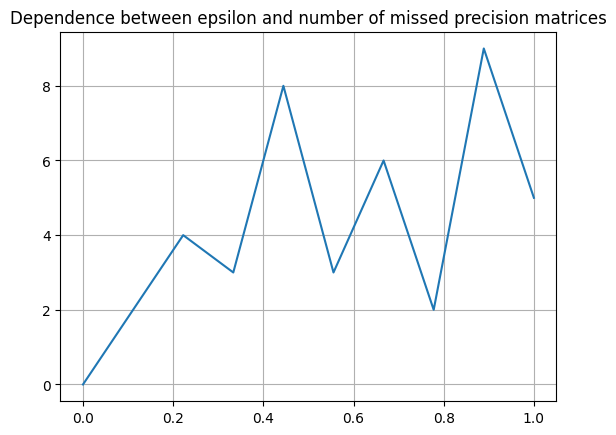

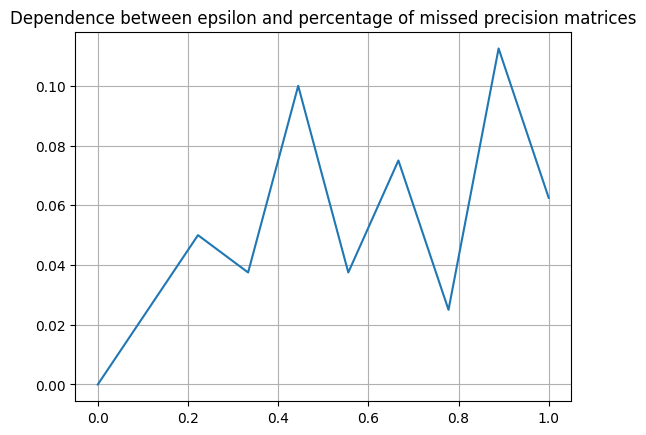

In [31]:
abs_missed = []
rel_missed = []

for k in eps_list:
    v = experiment_data[k]
    abs_missed.append(S_obs * S_sg - len(v))
    rel_missed.append((1 - len(v) / S_obs / S_sg) * 100)

plt.plot(eps_list, abs_missed)
plt.title("Dependence between epsilon and number of missed precision matrices")
plt.grid()
plt.show()

plt.plot(eps_list, rel_missed)
plt.title("Dependence between epsilon and percentage of missed precision matrices")
plt.grid()
plt.show()

In [42]:
x = eps_list
y = get_dependency(experiment_data, eps_list, matthews_corrcoef)

100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


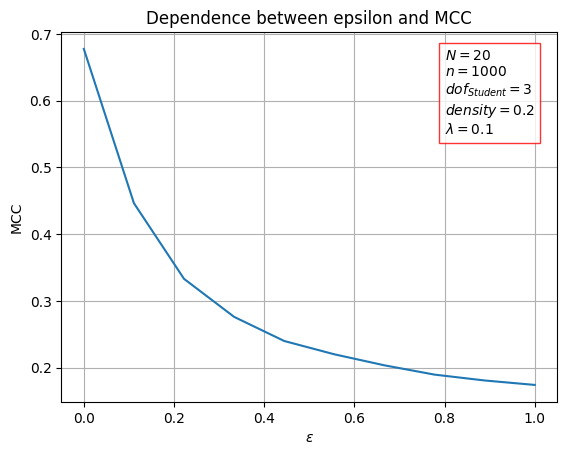

In [68]:
plt.plot(x, y)
plt.text(0.8, 0.55, "$N=20$\n$n=1000$\n$dof_{Student}=3$\n$density=0.2$\n$\lambda=0.1$", bbox=dict(facecolor='white', edgecolor='red', alpha=0.8))
plt.title("Dependence between epsilon and MCC")
plt.xlabel('$\epsilon$')
plt.ylabel('MCC')
plt.grid()
plt.show()